In [5]:
#not sure why we need to define these

def custom_transition_func(p):

    _T = transition_matrix(N=N, M=M, p=p, absorbing_states=goal_states)
    _T = insert_walls_into_T(T=_T, wall_indices=wall_states)
    return _T

def custom_gamma_func(gamma):
    return gamma

def custom_reward_func(big_reward_1, big_reward_2):
    reward_func = np.zeros((N, M))
    reward_func[N-1, 0] = big_reward_1
    reward_func[0,M-1] = big_reward_2
    # reward_func[N-1, M-1] = big_reward_3
    return reward_func.flatten()

In [19]:
import os, pickle
import numpy as np

import matplotlib.pyplot as plt


curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

def load_checkpoints(method_name):
    directory = f"checkpoints/checkpoints/maze/{method_name}"
    checkpoints = []
    for root, dirs, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            with open(filepath, "rb") as file:
                checkpoint = pickle.load(file)
                checkpoints.append(checkpoint)

    return checkpoints

checkpoints_amber = load_checkpoints("AMBER")
checkpoints_BIRL = load_checkpoints("BIRL")
checkpoints_EDBIRL = load_checkpoints("ED-BIRL")

## Plots on learning

In [137]:
import numpy as np
def return_cover_numbers(results, episode):

    cov_numbers = results["diagnostics"]["cover_numbers"][episode]

    covers_behavior_1 = []
    covers_behavior_2 = []

    for val in cov_numbers:
        if len(val) == 1:
            covers_behavior_1.append(0)
            covers_behavior_2.append(val[0])
        else:
            if val[0] < val[1]:
                covers_behavior_1.append(val[0])
                covers_behavior_2.append(val[1])
            else:
                covers_behavior_1.append(val[1])
                covers_behavior_2.append(val[0])

    return np.array([covers_behavior_1, covers_behavior_2])

def return_entropies(results, episode):

    entropies = results["diagnostics"]["entropy_BM"][episode]

    return entropies

def count_behaviors(results):

    goal_states = results[0]["base_environment"].goal_states
    array_behaviors = np.zeros((len(results), len(goal_states)))


    for idx, result in enumerate(results):
        count_behavior = {}
        for state in goal_states:
            count_behavior[state] = 0
        for behavior in result["all_observations"]:
            final_state = behavior[1][0][-1][0]
            try:
                count_behavior[final_state] += 1
            except:
                pass
        array_behaviors[idx, :] = list(count_behavior.values())
    return array_behaviors

        

cov_numbers_episode_1 = return_cover_numbers(results = checkpoints_amber[0], episode=1)
cov_numbers_episode_3 = return_cover_numbers(results = checkpoints_amber[0], episode=3)
cov_numbers_episode_5 = return_cover_numbers(results = checkpoints_amber[0], episode=5)

entropies_episode_1 = return_entropies(results = checkpoints_amber[0], episode=1)
entropies_episode_3 = return_entropies(results = checkpoints_amber[0], episode=3)
entropies_episode_5 = return_entropies(results = checkpoints_amber[0], episode=5)

max_entropy = 0.6931471805599453


In [154]:
behavior_counts_amber = count_behaviors(checkpoints_amber)
behavior_counts_BIRL = count_behaviors(checkpoints_BIRL)
behavior_counts_EDBIRL = count_behaviors(checkpoints_EDBIRL)

#some error here, normalize to 15 observations
for row in range(behavior_counts_amber.shape[0]):
    behavior_counts_amber[row, :] = 15*behavior_counts_amber[row, :] / np.sum(behavior_counts_amber[row, :])
for row in range(behavior_counts_BIRL.shape[0]):
    behavior_counts_BIRL[row, :] = 15*behavior_counts_BIRL[row, :] / np.sum(behavior_counts_BIRL[row, :])
for row in range(behavior_counts_EDBIRL.shape[0]):
    behavior_counts_EDBIRL[row, :] = 15*behavior_counts_EDBIRL[row, :] / np.sum(behavior_counts_EDBIRL[row, :])

mean_behavior_1_amber = np.mean(behavior_counts_amber[:, 0])
mean_behavior_2_amber = np.mean(behavior_counts_amber[:, 1])
std_behavior_1_amber = np.std(behavior_counts_amber[:, 0])
std_behavior_2_amber = np.std(behavior_counts_amber[:, 1])

mean_behavior_1_BIRL = np.mean(behavior_counts_BIRL[:, 0])
mean_behavior_2_BIRL = np.mean(behavior_counts_BIRL[:, 1])
std_behavior_1_BIRL = np.std(behavior_counts_BIRL[:, 0])
std_behavior_2_BIRL = np.std(behavior_counts_BIRL[:, 1])

mean_behavior_1_EDBIRL = np.mean(behavior_counts_EDBIRL[:, 0])
mean_behavior_2_EDBIRL = np.mean(behavior_counts_EDBIRL[:, 1])
std_behavior_1_EDBIRL = np.std(behavior_counts_EDBIRL[:, 0])
std_behavior_2_EDBIRL = np.std(behavior_counts_EDBIRL[:, 1])

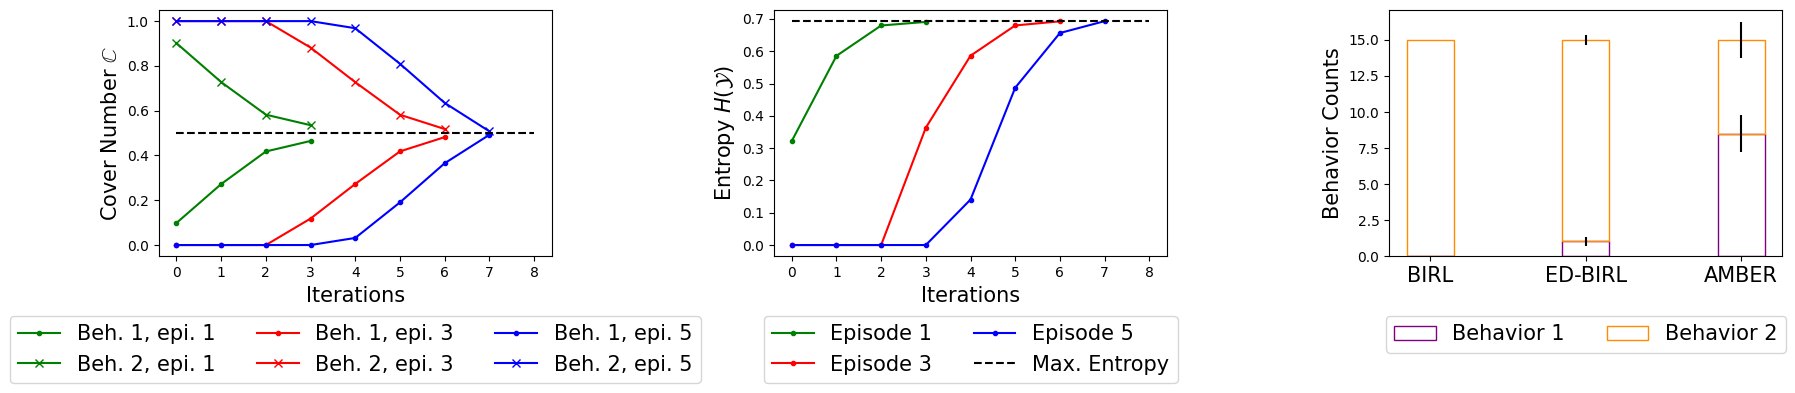

In [184]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
fontsize = 15
yshift_legend = 0.2

axs[0].plot(cov_numbers_episode_1[0], "g.-", label="Beh. 1, epi. 1")
axs[0].plot(cov_numbers_episode_1[1], "g-x", label="Beh. 2, epi. 1")
axs[0].plot(cov_numbers_episode_3[0], "r.-", label="Beh. 1, epi. 3")
axs[0].plot(cov_numbers_episode_3[1], "r-x", label="Beh. 2, epi. 3")
axs[0].plot(cov_numbers_episode_5[0], "b.-", label="Beh. 1, epi. 5")
axs[0].plot(cov_numbers_episode_5[1], "b-x", label="Beh. 2, epi. 5")
axs[0].set_xlabel("Iterations", size=fontsize)
axs[0].set_ylabel("Cover Number $\mathbb{C}$", size=fontsize)
axs[0].hlines(0.5, 0, 8, colors="black", linestyles="dashed")
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -yshift_legend), ncols = 3, fontsize=fontsize)

axs[1].plot(entropies_episode_1, "g.-", label="Episode 1")
axs[1].plot(entropies_episode_3, "r.-", label="Episode 3")
axs[1].plot(entropies_episode_5, "b.-", label="Episode 5")
axs[1].set_xlabel("Iterations", size=fontsize)
axs[1].set_ylabel("Entropy $H(\mathcal{Y})$", size=fontsize)
axs[1].hlines(max_entropy, 0, 8, colors="black", linestyles="dashed", label = "Max. Entropy")
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -yshift_legend), ncols = 2, fontsize=fontsize)

mean_1 = [mean_behavior_1_BIRL, mean_behavior_1_EDBIRL, mean_behavior_1_amber]
mean_2 = [mean_behavior_2_BIRL, mean_behavior_2_EDBIRL, mean_behavior_2_amber]
yerr_1 = [std_behavior_1_BIRL, std_behavior_1_EDBIRL, std_behavior_1_amber]
yerr_2 = [std_behavior_2_BIRL, std_behavior_2_EDBIRL, std_behavior_2_amber]
axs[2].bar([1, 2, 3], mean_1, yerr=yerr_1, color="blue", label="Behavior 1", width=0.3, fill=False, edgecolor="purple")
axs[2].bar([1, 2, 3], mean_2, yerr=yerr_2, color="red", label="Behavior 2", bottom=mean_1, width=0.3, fill=False, edgecolor="darkorange")
axs[2].set_xticks([1, 2, 3])
axs[2].set_xticklabels(["BIRL", "ED-BIRL", "AMBER"], size=fontsize)
axs[2].set_ylabel("Behavior Counts", size=fontsize)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -yshift_legend), ncols = 2, fontsize=fontsize)

fig.tight_layout()

fig.tight_layout()

## Parameter Inference

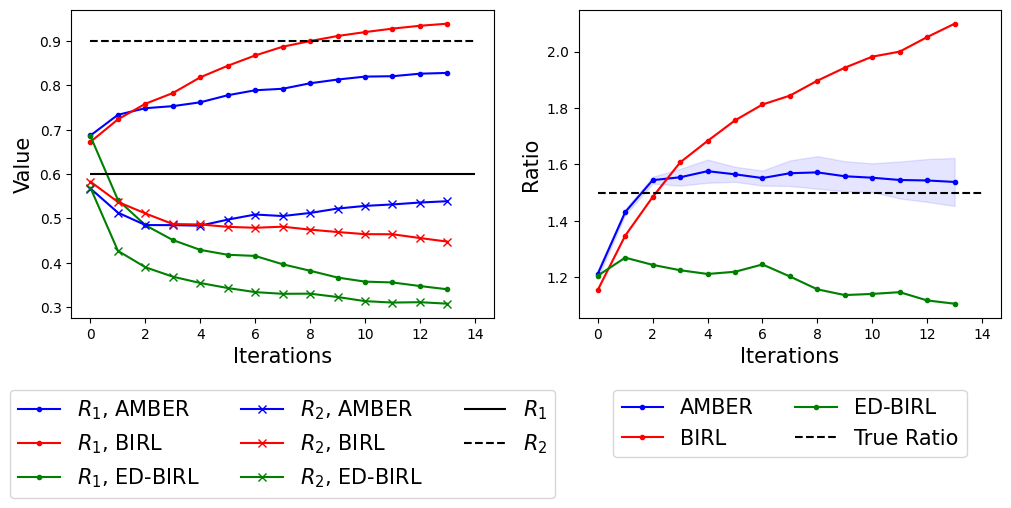

In [222]:
def load_mean_params(results):
    mean_params = np.array(results[0]["diagnostics"]["parameter_means"])
    _n_episodes = mean_params.shape[0]
    _n_parameters = mean_params.shape[1]
    _n_results = len(results)
    mean_params = np.zeros((_n_episodes, _n_parameters, _n_results))
    for idx, result in enumerate(results):
        mean_params[:,:,idx] = np.array(result["diagnostics"]["parameter_means"])

    return mean_params

mean_params_amber = load_mean_params(checkpoints_amber)
mean_params_BIRL = load_mean_params(checkpoints_BIRL)
mean_params_EDBIRL = load_mean_params(checkpoints_EDBIRL)

mean_across_runs_amber = np.mean(mean_params_amber, axis=2)
mean_across_runs_BIRL = np.mean(mean_params_BIRL, axis=2)
mean_across_runs_EDBIRL = np.mean(mean_params_EDBIRL, axis=2)
var_across_runs_amber = np.var(mean_params_amber, axis=2)
var_across_runs_BIRL = np.var(mean_params_BIRL, axis=2)
var_across_runs_EDBIRL = np.var(mean_params_EDBIRL, axis=2)

true_values = checkpoints_amber[0]["user_params"]


ratios_amber = mean_across_runs_amber[:,0]/mean_across_runs_amber[:,-1]
ratios_BIRL = mean_across_runs_BIRL[:,0]/mean_across_runs_BIRL[:,-1]
ratios_EDBIRL = mean_across_runs_EDBIRL[:,0]/mean_across_runs_EDBIRL[:,-1]
ratio_true = true_values.R[0]/true_values.R[1]


num_episodes = len(mean_across_runs_amber[:, 0])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(mean_across_runs_amber[:, 0], "b.-", label="$R_1$, AMBER")
axs[0].plot(mean_across_runs_BIRL[:, 0], "r.-", label="$R_1$, BIRL")
axs[0].plot(mean_across_runs_EDBIRL[:, 0], "g.-", label="$R_1$, ED-BIRL")
axs[0].plot(mean_across_runs_amber[:, 1], "b-x", label="$R_2$, AMBER")
axs[0].plot(mean_across_runs_BIRL[:, 1], "r-x", label="$R_2$, BIRL")
axs[0].plot(mean_across_runs_EDBIRL[:, 1], "g-x", label="$R_2$, ED-BIRL")
axs[0].hlines(true_values.R[1], 0, num_episodes, colors="black", linestyles="-", label = "$R_1$")
axs[0].hlines(true_values.R[0], 0, num_episodes, colors="black", linestyles="--", label = "$R_2$")
axs[0].set_ylabel("Value", fontsize=fontsize)
axs[0].set_xlabel("Iterations", fontsize=fontsize)
axs[0].legend()
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -yshift_legend), ncols = 3, fontsize=fontsize)

axs[1].plot(ratios_amber, "b.-", label="AMBER")
axs[1].plot(ratios_BIRL, "r.-", label="BIRL")
axs[1].plot(ratios_EDBIRL, "g.-", label="ED-BIRL")
axs[1].fill_between(np.arange(num_episodes), ratios_amber-np.sqrt(var_across_runs_amber[:,0])/mean_across_runs_amber[:,0], ratios_amber+np.sqrt(var_across_runs_amber[:,0])/mean_across_runs_amber[:,0], color="blue", alpha=0.1)
axs[1].fill_between(np.arange(num_episodes), ratios_BIRL-np.sqrt(var_across_runs_BIRL[:,0])/mean_across_runs_BIRL[:,0], ratios_BIRL+np.sqrt(var_across_runs_BIRL[:,0])/mean_across_runs_BIRL[:,0], color="red", alpha=0.1)
axs[1].fill_between(np.arange(num_episodes), ratios_EDBIRL-np.sqrt(var_across_runs_EDBIRL[:,0])/mean_across_runs_EDBIRL[:,0], ratios_EDBIRL+np.sqrt(var_across_runs_EDBIRL[:,0])/mean_across_runs_EDBIRL[:,0], color="green", alpha=0.1)
axs[1].hlines(ratio_true, 0, num_episodes, colors="black", linestyles="--", label = "True Ratio")
axs[1].set_ylabel("Ratio", fontsize=fontsize)
axs[1].set_xlabel("Iterations", fontsize=fontsize)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -yshift_legend), ncols = 2, fontsize=fontsize)